# Nashville AirBNB

#### Objective:

You have contracted with InsideAirbnb.com to provide insight into the data that hs been collected.

You are charged with the following:
- Visualize, summarize or explore an interesting insight from the data that you think would be interesting and that could be added to the dashboard (see above image) on the website.
- Create a model that will make a numerical prediction that will be interesting for InsideAirbnb.com. It is your choice on the numerical target variable.
- You are looking for the best prediction AND the most significant features.
- Create a model that will predict a label to help make a decision.
- You most likely will need to create your own y target variable which will be two choices (ex. yes or no, false or true, 0 or 1).
- It is your choice on the objective, the type of model(s), and the y target variable.

### Import Libraries

In [1]:
# Code Block 1

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline

from numpy import arange
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.metrics import precision_recall_curve, r2_score, f1_score, make_scorer, ConfusionMatrixDisplay, mean_squared_error, confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.impute import SimpleImputer

# Set display options and configurations
pd.set_option('display.max_columns', 500)
plt.style.use('seaborn-v0_8-whitegrid')
import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
# Load the datasets
amenities = pd.read_csv('data/amenitiesdummies_top87.csv')
hosts = pd.read_csv('data/hosts.csv')
listings = pd.read_csv('data/listings.csv.gz', compression='gzip', index_col=None, header=0, sep=',', quotechar='"')
calendar = pd.read_csv('data/calendar.csv.gz', compression='gzip', index_col=None, header=0, sep=',', quotechar='"')
reviews = pd.read_csv('data/reviews.csv.gz', compression='gzip', index_col=None, header=0, sep=',', quotechar='"')
listings_review = pd.read_csv('data/listings.csv.gz', compression='gzip', index_col=None, header=0, sep=',', quotechar='"')

# Initial exploration to understand the structure of each dataset
datasets = {
    "amenities": amenities.head(),
    "listings": listings.head(),
    "calendar": calendar.head(),
    "hosts": hosts.head(),
    "reviews": reviews.head()
}

datasets

{'amenities':    Index  Wifi  Smokealarm  Heating  Airconditioning  TV  Essentials  \
 0      0     1           1        1                1   1           1   
 1      1     1           1        1                1   1           0   
 2      2     1           1        1                1   1           1   
 3      3     1           1        1                1   1           1   
 4      4     1           1        1                1   1           1   
 
    Hairdryer  Iron  Hangers  Kitchen  Longtermstaysallowed  Shampoo  \
 0          1     1        1        1                     1        1   
 1          1     1        0        0                     0        0   
 2          0     0        0        1                     1        1   
 3          1     1        1        1                     1        1   
 4          1     1        1        1                     1        1   
 
    Freeparkingonpremises  Coffeemaker  Dryer  Washer  Hotwater  \
 0                      0            1      0 

Given the datasets, some insights I'd like to explore involves analyzing the relationship between different factors and their effect on listing prices. Then, I will predict listing popularity by creating a binary target variable indicating whether a listing is popular or not, based on metrics such as the number of reviews, review scores, or a combination of both. For instance, a listing could be considered "popular" (label 1) if it has a high number of reviews and above-average review scores, and "not popular" (label 0) otherwise. 

### Data Exploration

#### Insights for Dashboard Visualizations

##### Chart containing the top 10 amenities with the greatest positive difference in average price

In [3]:
# Assuming the datasets are aligned based on row order, we'll add the 'id' column from listings to amenities for a clear identifier
amenities['id'] = listings['id']

# Convert the 'price' column in listings to a numerical format
# First, we'll remove any currency symbols and commas, then convert to float
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

# Merge the datasets on the 'id' column
merged = pd.merge(amenities, listings[['id', 'price']], on='id')

# Now that we have the merged dataset, we can calculate the average price for listings with and without each amenity
# Let's start with an example amenity to illustrate the process
amenity_example = 'Wifi'

# Calculate average price for listings with and without the example amenity
average_price_with_amenity = merged[merged[amenity_example] == 1]['price'].mean()
average_price_without_amenity = merged[merged[amenity_example] == 0]['price'].mean()

average_price_with_amenity, average_price_without_amenity

(233.41116078820997, 210.3904761904762)

In [4]:
# Calculate the average price for listings with and without each amenity

# Initialize a dictionary to store the average prices
average_prices = {}

# Iterate through each amenity column, excluding 'Index' and 'id'
for amenity in amenities.columns[:-1]:  # Exclude the last column which is 'id'
    with_amenity = merged[merged[amenity] == 1]['price'].mean()
    without_amenity = merged[merged[amenity] == 0]['price'].mean()
    
    # Store the averages in the dictionary
    average_prices[amenity] = {'with': with_amenity, 'without': without_amenity}

# Convert the dictionary to a DataFrame for easier visualization and analysis
average_prices_df = pd.DataFrame(average_prices).T

# Sort the DataFrame by the difference in price between listings with and without the amenities
average_prices_df['price_difference'] = average_prices_df['with'] - average_prices_df['without']
average_prices_df_sorted = average_prices_df.sort_values(by='price_difference', ascending=False)

# Display the top 10 amenities with the greatest positive difference in average price
average_prices_df_sorted.head(10)

,with,without,price_difference
Crib,568.589041,224.849450,343.739591
Lockonbedroomdoor,488.250000,213.522074,274.727926
EVcharger,470.561111,225.848424,244.712687
Highchair,382.755682,223.917645,158.838037
TV,239.603669,129.046448,110.557221
Pool,316.676520,213.047581,103.628940
Gym,313.326496,214.127262,99.199234
Firstaidkit,280.471498,184.533399,95.938098
Carbonmonoxidealarm,250.662513,173.721789,76.940725
Longtermstaysallowed,241.033321,183.901392,57.131929


##### Creating a bar plot for the price difference of the top 10 amenities

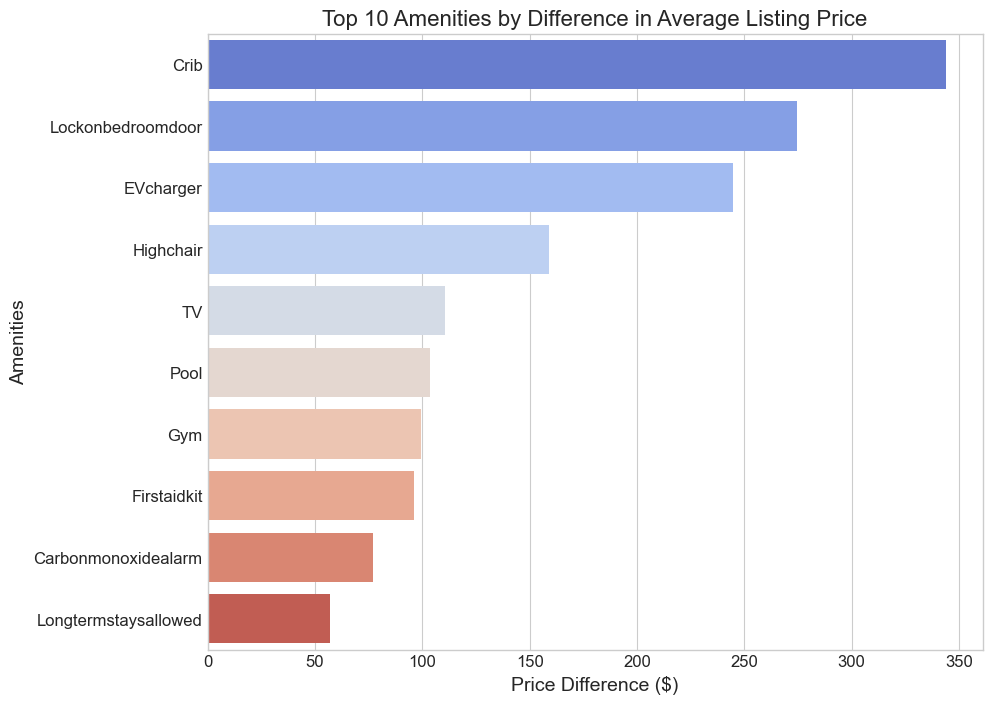

In [5]:
# Plotting the top 10 amenities with the greatest positive difference in price
top_10_amenities = average_prices_df_sorted.head(10)

# Create a bar plot for the price difference of top 10 amenities
plt.figure(figsize=(10, 8))
sns.barplot(x=top_10_amenities['price_difference'], y=top_10_amenities.index, palette="coolwarm")
plt.title('Top 10 Amenities by Difference in Average Listing Price', fontsize=16)
plt.xlabel('Price Difference ($)', fontsize=14)
plt.ylabel('Amenities', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The findings above indicate that certain amenities, like cribs, locks on bedroom doors, and EV chargers, significantly increase a listing's average price, suggesting these features are highly valued by renters or guests. Conversely, amenities like long-term stays allowed, while still adding value, have a less dramatic impact on listing prices.

##### Price difference by room type

In [6]:
# Group data by room_type and calculate average price
average_prices_by_room_type = listings.groupby('room_type')['price'].mean().reset_index()

# Sort the results for better visualization
average_prices_by_room_type = average_prices_by_room_type.sort_values(by='price', ascending=False)

average_prices_by_room_type

,room_type,price
1,Hotel room,530.424242
2,Private room,368.273141
0,Entire home/apt,213.338086
3,Shared room,95.666667


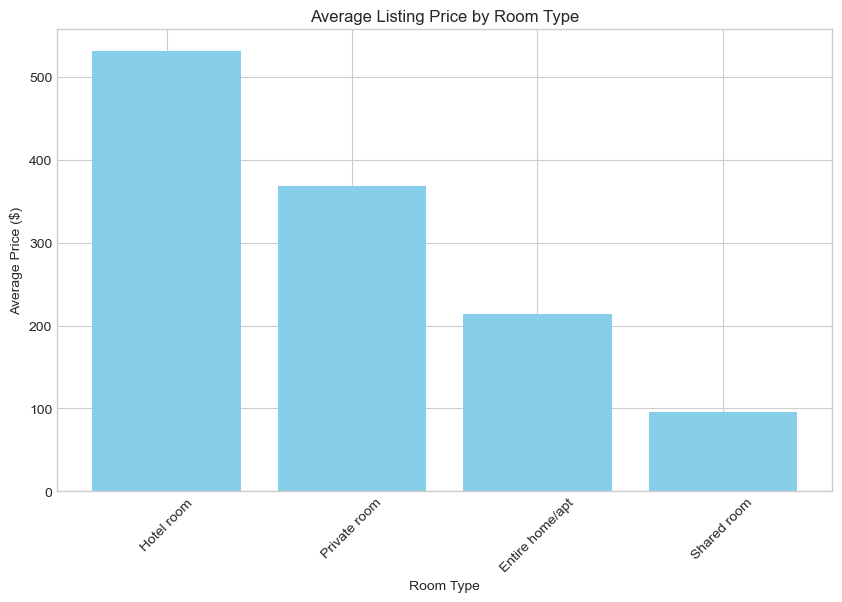

In [7]:
plt.figure(figsize=(10, 6))
plt.bar(average_prices_by_room_type['room_type'], average_prices_by_room_type['price'], color='skyblue')
plt.title('Average Listing Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45)
plt.show()

##### Price difference of the top 10 neighborhoods

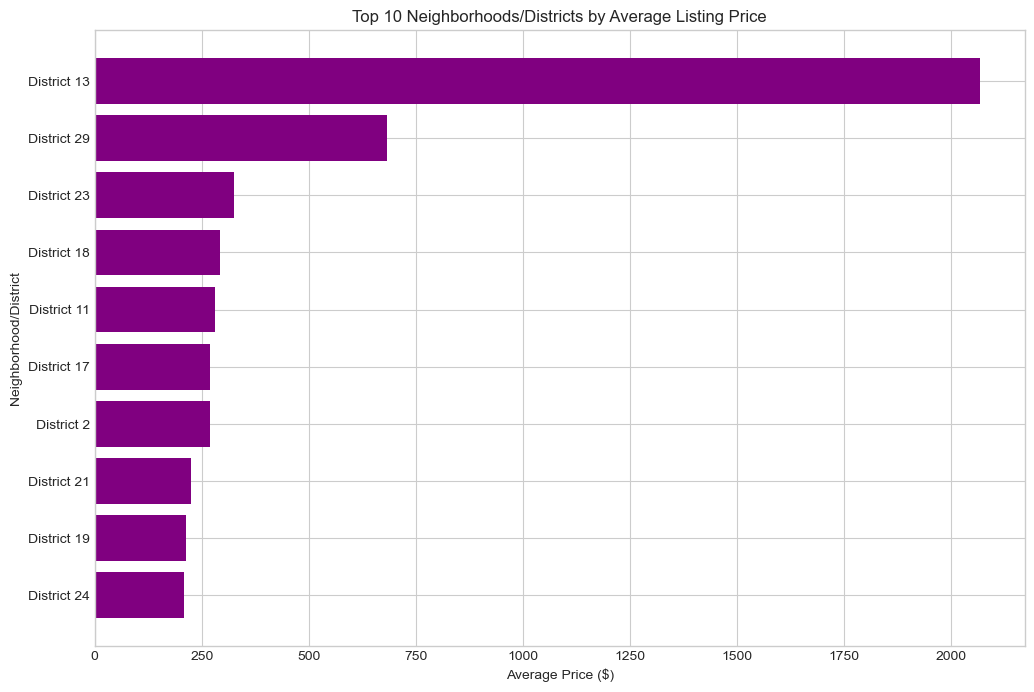

In [8]:
# Group data by neighbourhood_cleansed and calculate average price
average_prices_by_neighborhood = listings.groupby('neighbourhood_cleansed')['price'].mean().reset_index()

# Sort the results for better visualization, keeping the top 10 for clarity
average_prices_by_neighborhood_sorted = average_prices_by_neighborhood.sort_values(by='price', ascending=False).head(10)

plt.figure(figsize=(12, 8))
plt.barh(average_prices_by_neighborhood_sorted['neighbourhood_cleansed'], average_prices_by_neighborhood_sorted['price'], color='purple')
plt.title('Top 10 Neighborhoods/Districts by Average Listing Price')
plt.xlabel('Average Price ($)')
plt.ylabel('Neighborhood/District')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest price on top
plt.show()

##### Is there a relationship between reviews and prices?

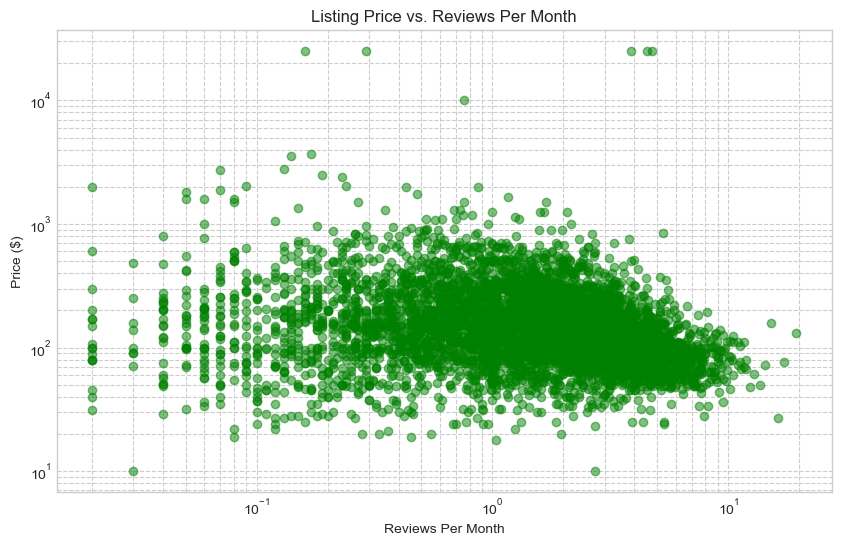

In [9]:
# Filter out listings with no reviews to focus on those with at least one review
listings_with_reviews = listings[listings['reviews_per_month'].notnull()]

# Scatter plot for relation between reviews per month and listing prices
plt.figure(figsize=(10, 6))
plt.scatter(listings_with_reviews['reviews_per_month'], listings_with_reviews['price'], alpha=0.5, color='green')
plt.title('Listing Price vs. Reviews Per Month')
plt.xlabel('Reviews Per Month')
plt.ylabel('Price ($)')
plt.xscale('log')  # Log scale for better visualization of spread
plt.yscale('log')  # Log scale for price due to wide range
plt.grid(True, which="both", ls="--")
plt.show()

### Predictive Modeling

#### Using Lasso regression technique to predict price based on a neighborhood. 

For the initial model, the target variable will be the price of the listings. The goal is to predict price based on the neighborhood. Lasso regression will be performed since price is a continuous variable; however, since neighborhood is categorical, it will be onehot encoded.

In [10]:
y = listings['price'].values

# Scale the numerical features in listings
scaler = StandardScaler()
listings_scaled = scaler.fit_transform(listings.select_dtypes(include=['float64', 'int64']))

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# One-hot encode the categorical feature 'neighbourhood_cleansed'
X = encoder.fit_transform(listings[['neighbourhood_cleansed']])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

##### Prelimary lasso model, without any optimization

In [12]:
# Set
lasso = Lasso(alpha=0.5, fit_intercept=True)

# Fit
lasso.fit(X_train, y_train)

Lasso(alpha=0.5)

In [13]:
# Predict
lasso_pred = lasso.predict(X_test)

# Assess 
lasso.score(X_test, y_test)

0.060756996334354274

##### Preliminary Lasso Model:
- Alpha (Regularization Strength): Initially set to 0.5.
- R-squared Score: The R-squared score obtained on the test set is approximately 0.0608, which indicates that the model explains only about 6.08% of the variance in the target variable (price).

iteration 0.1 done
iteration 0.5 done
iteration 1 done
iteration 5 done
iteration 7 done
iteration 10 done
iteration 15 done
iteration 20 done
iteration 25 done
iteration 50 done


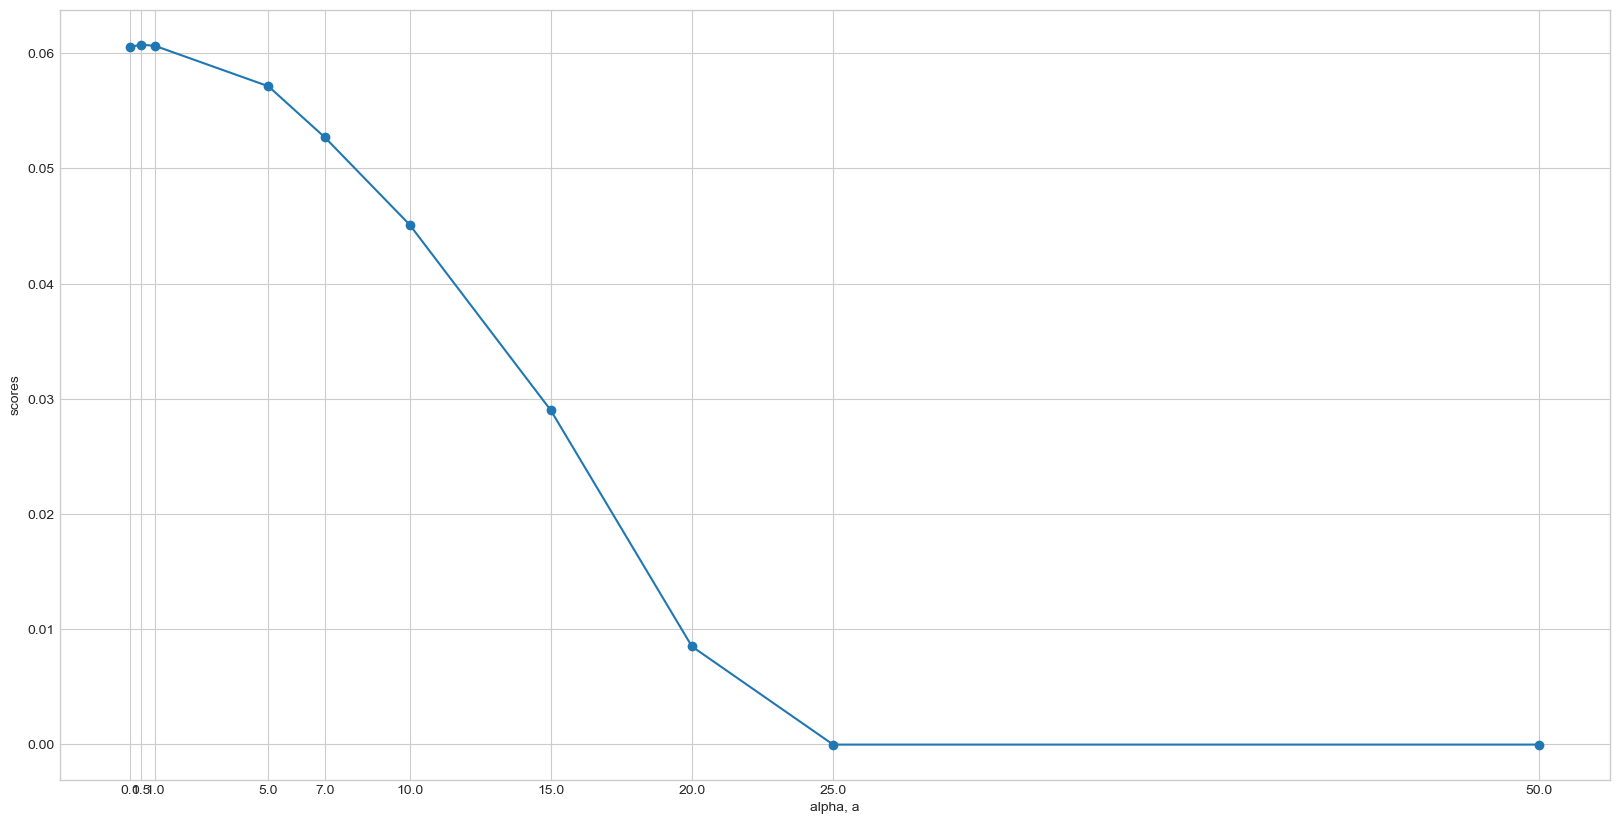

In [14]:
plt.figure(figsize=(20,10))

#alphas = [0.001, 0.005, 0.01,  0.05, 0.1, 0.25, 0.5, 1]
alphas = [0.1, 0.5, 1, 5, 7, 10, 15,20, 25, 50]
scores = []

for a in alphas:
    #lasso = Lasso(alpha = a, fit_intercept=True, normalize = True)
    lasso = Lasso(alpha = a, fit_intercept=True)
    
    lasso.fit(X_train, y_train)
    scores.append(lasso.score(X_test, y_test))
    print("iteration {} done".format(a))


plt.plot(alphas, scores, '-o')
plt.xlabel('alpha, a')
plt.ylabel('scores')
plt.xticks(alphas)
plt.show()

In [15]:
lascores01 = cross_val_score(Lasso( fit_intercept=True, max_iter=3000, alpha= 0.1), X, y, cv=5, scoring = 'r2')

lascores05 = cross_val_score(Lasso( fit_intercept=True, max_iter=3000, alpha= 0.5), X, y, cv=5, scoring = 'r2')

lascores1 = cross_val_score(Lasso(fit_intercept=True,  max_iter=3000, alpha= 1), X, y, cv=5, scoring = 'r2')

# Put r-squared values into a dataframe with headers
scores_list = {'lambda=01': lascores01,'lambda=05': lascores05,'lambda=1': lascores1}

df_lassoscores = pd.DataFrame(scores_list)

# Show results of 10 runs for each lambda (alpha) level
print('Lasso Regression Results')
df_lassoscores

Lasso Regression Results


,lambda=01,lambda=05,lambda=1
0,-5.446706,-5.280292,-5.091540
1,-1.292291,-1.244772,-1.192965
2,0.012525,0.011022,0.008490
3,0.068059,0.067521,0.066466
4,-0.498931,-0.483398,-0.460845


In [16]:
lasso = Lasso(alpha=0.1, fit_intercept=True, max_iter=3000)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1, max_iter=3000)

In [17]:
lasso_pred = lasso.predict(X_test)
lasso_pred

array([204.25774171, 169.15437264, 204.25774171, ..., 203.36850488,
       232.20628419, 324.48552756])

In [18]:
lasso_pred = lasso.predict(X_test)
df_lasso_pred = pd.DataFrame(lasso_pred, columns = ['lasso_pred'])
df_lasso_pred.head()

,lasso_pred
0,204.257742
1,169.154373
2,204.257742
3,170.466550
4,170.466550


##### Results of Alpha Optimization:
- Cross-Validation Scores: The cross-validation results for different values of alpha are presented in a DataFrame. It includes R-squared values obtained for alpha values of 0.1, 0.5, and 1.
- Interpretation: These scores indicate the performance of the model with different regularization strengths. Lower alpha values (0.1) tend to yield better R-squared scores compared to higher alpha values, indicating better model fit.

In [19]:
lasso.score(X_test, y_test)

0.06054609175465131

In [20]:
lasso.coef_

array([  -0.        ,   18.14789729,    0.        ,  -50.93166191,
       1778.18156172,   -9.73827477,   -2.01246634,    0.        ,
        118.18172858,  173.47905222,   52.36202954,   81.19980885,
         47.14834911,   75.61862265,   -0.        ,  217.06106273,
         68.54548642,    7.60827722,   -5.92274214,   -0.        ,
         -0.        ,  715.11539675,   -0.        ,  -11.58644888,
        -39.34283233,  -28.84279661,   -0.        ,   -0.        ,
         15.59930079,  -39.7740502 ,   53.25126637,   19.46007498,
        -10.99373011,   -8.40376727,   -4.4610208 ])

In [21]:
# Get feature names after one-hot encoding
feature_names = encoder.get_feature_names_out(['neighbourhood_cleansed'])

# Create a DataFrame to store the coefficients
df_lasso = pd.DataFrame(lasso.coef_, columns=['lasso_coeff_0.1'])

# Assign feature names to the DataFrame
df_lasso['Feature'] = feature_names

# Reorder columns and sort by coefficient values
df_lasso = df_lasso[['Feature', 'lasso_coeff_0.1']]
df_lasso = df_lasso.sort_values(by='lasso_coeff_0.1', ascending=False)

# Print the DataFrame
print(df_lasso)

                               Feature  lasso_coeff_0.1
4   neighbourhood_cleansed_District 13      1778.181562
21  neighbourhood_cleansed_District 29       715.115397
15  neighbourhood_cleansed_District 23       217.061063
9   neighbourhood_cleansed_District 18       173.479052
8   neighbourhood_cleansed_District 17       118.181729
11   neighbourhood_cleansed_District 2        81.199809
13  neighbourhood_cleansed_District 21        75.618623
16  neighbourhood_cleansed_District 24        68.545486
30   neighbourhood_cleansed_District 5        53.251266
10  neighbourhood_cleansed_District 19        52.362030
12  neighbourhood_cleansed_District 20        47.148349
31   neighbourhood_cleansed_District 6        19.460075
1   neighbourhood_cleansed_District 10        18.147897
28  neighbourhood_cleansed_District 35        15.599301
17  neighbourhood_cleansed_District 25         7.608277
27  neighbourhood_cleansed_District 34        -0.000000
26  neighbourhood_cleansed_District 33        -0

In [22]:
lasso.intercept_

151.00647534495786

##### Coefficient Analysis:
- Feature Importance: The coefficients obtained from the final Lasso model after optimization provide insights into the importance of each neighborhood district in predicting the price.
- Positive and Negative Influences: Some districts have positive coefficients, indicating they positively impact the price, while others have negative coefficients, indicating a negative impact. The magnitude of the coefficients reflects the strength of influence.

##### Model Interpretation:
- Intercept: The intercept obtained from the model is approximately 151.0065, which represents the baseline price when all other predictors are zero.

##### Visualizations of the lasso coefficients

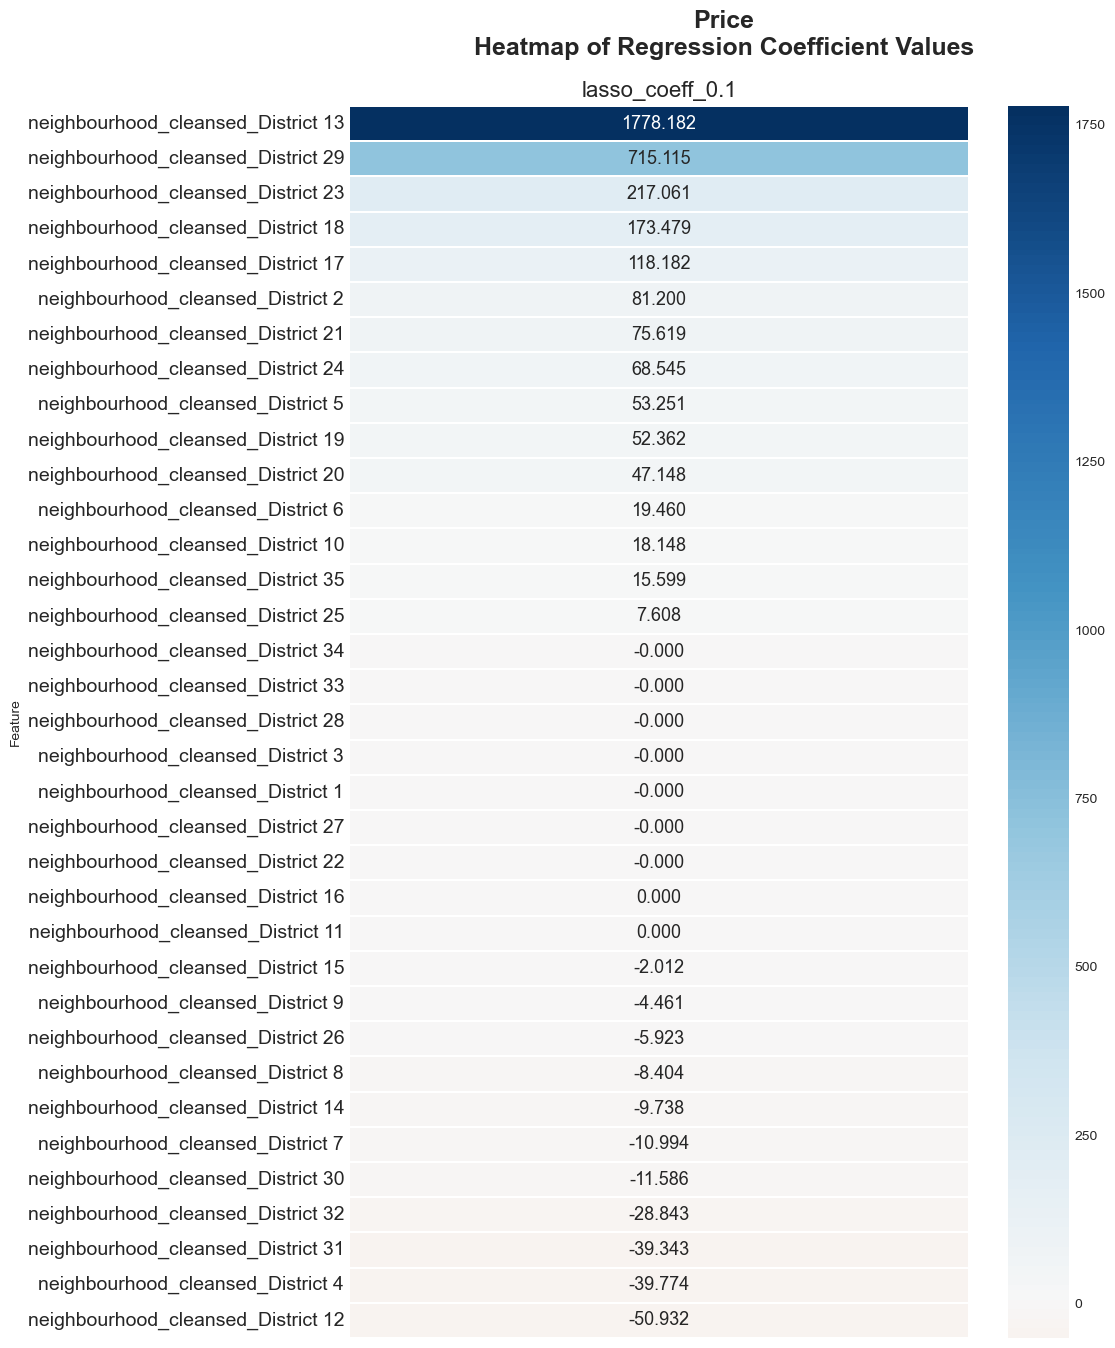

In [23]:
# Show coefficient values in a heatmap
df_coef = df_lasso.set_index('Feature')

index = df_coef.index
plt.figure(figsize=(10,16))
ax = sns.heatmap(df_coef, linewidths=0.1, center = 0, cmap='RdBu', linecolor='white', 
            annot=True, fmt=".3f", annot_kws={"size": 13})
ax.xaxis.tick_top()    # Put x labels at top of plot
ax.set_xticklabels(df_coef.columns.values, fontsize = 16)
ax.set_yticklabels(index, fontsize = 14)
plt.suptitle('Price\nHeatmap of Regression Coefficient Values', fontweight='bold', 
          fontsize='18', ha='center', y=.94)
plt.show()

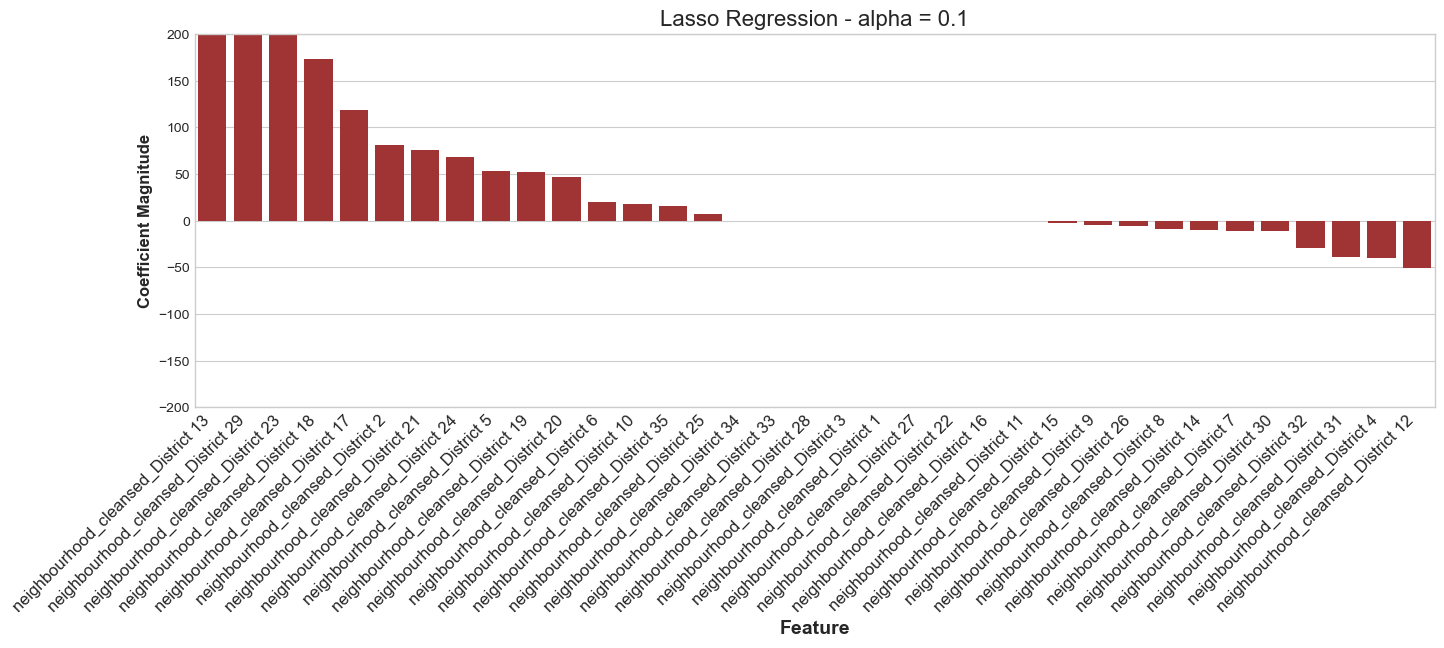

In [24]:
plt.figure(figsize=(16,16))
plt.subplots_adjust(hspace=0.15)

# Create a bar plot of regression coefficients for lasso regression
plt.subplot(313)
chart3 = sns.barplot(x = index, y = "lasso_coeff_0.1", data = df_coef, color = 'firebrick')
chart3.set_title("Lasso Regression - alpha = 0.1", fontdict = {'fontsize' : 16})
chart3.set_ylim([-200, 200])
chart3.set_ylabel('Coefficient Magnitude', fontweight='bold', fontsize='12', ha='center')
chart3.set_xticklabels(index, rotation=45, ha='right', fontsize='12')
chart3.set_xlabel('Feature', fontweight='bold', fontsize='14', ha='center')

plt.show()

##### Overall Evaluation:
- Model Performance: The preliminary Lasso model showed limited predictive power, as indicated by the low R-squared value. However, optimization of the alpha parameter improved model performance.
- Feature Importance: The coefficients obtained from the optimized Lasso model provide valuable insights into the influence of different neighborhood districts on the price.
- Further Analysis: Further analysis, such as feature engineering or incorporating additional features, may enhance the predictive capability of the model.

##### Recommendations:
- Refinement: Refine the model by exploring additional hyperparameters, feature engineering, or alternative algorithms to improve predictive performance.
- Validation: Validate the model's performance on unseen data to ensure its generalizability.
- Business Insights: Use the model insights to make informed decisions, such as pricing strategies or neighborhood assessments, in the real estate domain.

#### Using Logistic and Decision Tree to determine if a listing will have a high level of guest satisfaction

#### Data Preprocessing

In [25]:
# Create the binary label for guest satisfaction
listings_review['high_guest_satisfaction'] = (listings_review['review_scores_rating'] > 80).astype(int)

##### Initial Logistic model (raw data)

Best parameters found:  {'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__class_weight': {0: 1, 1: 1.5}, 'classifier__C': 0.1}
Best cross-validation score:  0.9835198372329602
Accuracy on test set:  0.9780309194467046
Confusion Matrix:
 [[215  24]
 [  3 987]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94       239
           1       0.98      1.00      0.99       990

    accuracy                           0.98      1229
   macro avg       0.98      0.95      0.96      1229
weighted avg       0.98      0.98      0.98      1229



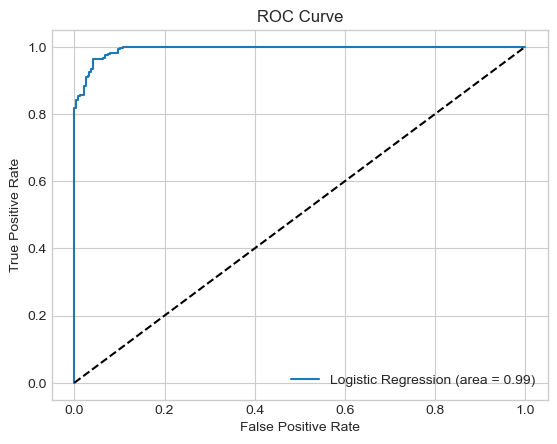

In [26]:
# Define feature and target variables
feature_columns = listings_review.columns.difference(['high_guest_satisfaction', 'review_scores_rating'])
X = listings_review[feature_columns]
y = listings_review['high_guest_satisfaction']

# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

# Define preprocessing for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Create a preprocessing and logistic regression model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 5, 10],
    'classifier__penalty': ['l2'],
    'classifier__class_weight': [None, 'balanced', {0:1, 1:1.5}, {0:1, 1:2}, {0:1, 1:3}, {0:1, 1:5}],
    'classifier__solver': ['lbfgs', 'liblinear']
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the RandomizedSearchCV to find the best model
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

# Use the best estimator to make predictions
y_pred = random_search.predict(X_test)

# Evaluate the model
print("Accuracy on test set: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot ROC Curve
y_pred_prob = random_search.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc_score(y_test, y_pred_prob))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

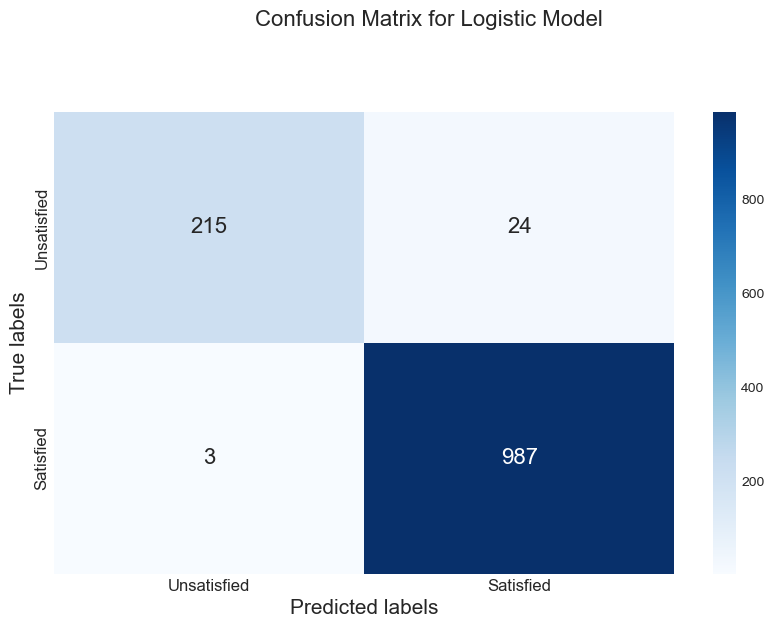

In [30]:
cm_opt = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 6))
fig.suptitle('Confusion Matrix for Logistic Model', fontsize=16, y=1.05)
ax = plt.subplot()

sns.heatmap(cm_opt, annot=True, cmap="Blues", annot_kws={"size": 16}, ax=ax, fmt="g")

ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('True labels', fontsize=15)
ax.xaxis.set_ticklabels(['Unsatisfied', 'Satisfied'], fontsize=12)  
ax.yaxis.set_ticklabels(['Unsatisfied', 'Satisfied'], fontsize=12, va='center')  

plt.show()

##### Summary of results: 

##### Accuracy Score: 0.9780:
This high accuracy score suggests that the model is correctly predicting whether a listing will have high guest satisfaction in approximately 97.8% of cases, indicating strong performance.

##### Confusion Matrix
- True Negatives (TN): 215 listings were correctly predicted as not having high guest satisfaction.
- False Negatives (FN): 24 listings were incorrectly predicted as not having high guest satisfaction.
- False Positives (FP): 3 listings were incorrectly predicted as having high guest satisfaction.
- True Positives (TP): 987 listings were correctly predicted as having high guest satisfaction.

The small number of false positives and false negatives relative to the true positives and true negatives further confirms the model's strong predictive capabilities.

##### Classification Report
- Precision for the negative class (0) is 0.99, and for the positive class (1) is 0.98. This high precision indicates a low false positive rate for both classes.
- Recall for the negative class is 0.90, indicating that 90% of the actual negative cases were correctly identified. For the positive class, the recall is practically perfect at 1.00, meaning almost all positive cases were correctly identified.
- F1-Score, which balances precision and recall, is 0.94 for the negative class and 0.99 for the positive class, reflecting the high overall accuracy of the model across both classes.

##### Cross-Validation: 0.9835
The cross-validation score indicates that the model is stable and generalizes well to unseen data. It suggests that the model's performance is not a fluke of the particular split of data it was trained on, and suggests that the model generalizes well and is not overfitting to the training data.

Overall, the model demonstrates excellent predictive performance, with high accuracy, precision, recall, F1-scores, and ROC AUC score. The consistency in cross-validation scores further validates the model's robustness and its ability to generalize well. 

#### Decision Tree

Best parameters found:  {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best cross-validation score:  0.9792472024415055
Accuracy on test set:  0.9764035801464606
Confusion Matrix:
 [[222  17]
 [ 12 978]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       239
           1       0.98      0.99      0.99       990

    accuracy                           0.98      1229
   macro avg       0.97      0.96      0.96      1229
weighted avg       0.98      0.98      0.98      1229



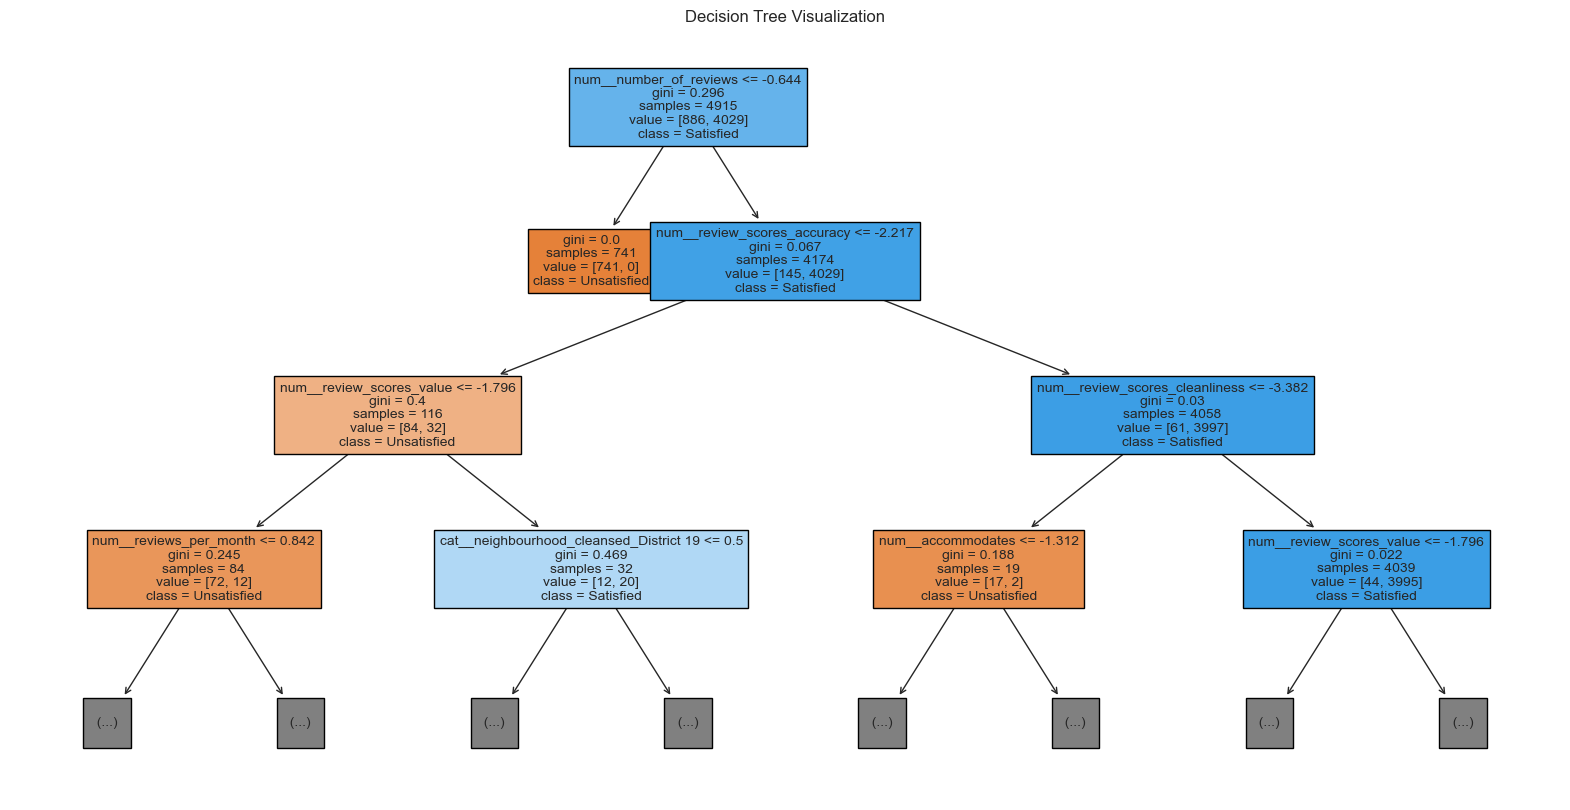

In [31]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Define the parameter grid for GridSearchCV 
param_grid = {
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Setup GridSearchCV 
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV to find the best model
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Use the best estimator to make predictions
y_pred = grid_search.predict(X_test)

# Evaluate the model
print("Accuracy on test set: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plotting the decision tree 

# Extract the best decision tree model from GridSearchCV
best_tree = grid_search.best_estimator_.named_steps['classifier']

# After fitting the GridSearchCV or your model, extract transformed feature names from the preprocessor
feature_names_transformed = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

# Convert the numpy array of feature names to a list
feature_names_list = feature_names_transformed.tolist()

# Now, plot the decision tree with the correct feature names
plt.figure(figsize=(20, 10))
plot_tree(best_tree, 
          filled=True, 
          feature_names=feature_names_list,  # Use the list version of feature names
          class_names=['Unsatisfied', 'Satisfied'], 
          max_depth=3, 
          fontsize=10)
plt.title('Decision Tree Visualization')
plt.show()

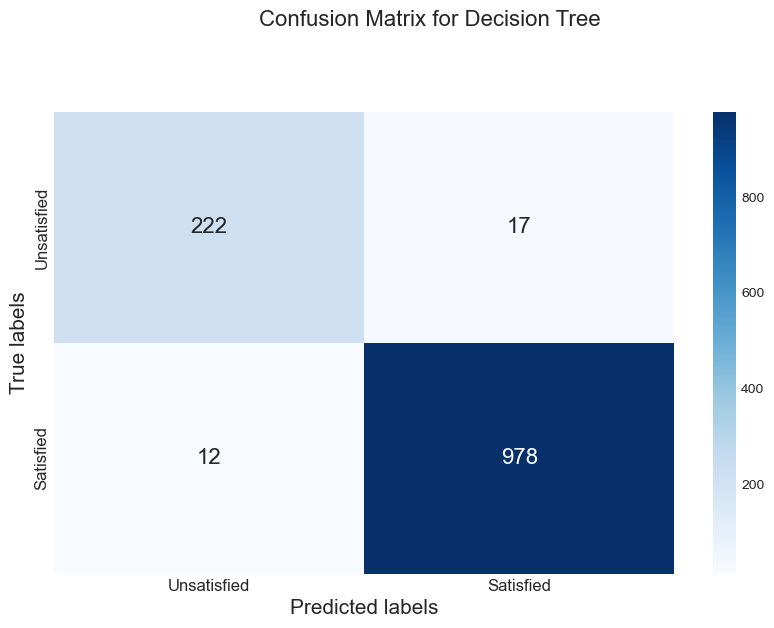

In [32]:
cm_opt = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 6))
fig.suptitle('Confusion Matrix for Decision Tree', fontsize=16, y=1.05)
ax = plt.subplot()

sns.heatmap(cm_opt, annot=True, cmap="Blues", annot_kws={"size": 16}, ax=ax, fmt="g")

ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('True labels', fontsize=15)
ax.xaxis.set_ticklabels(['Unsatisfied', 'Satisfied'], fontsize=12)  
ax.yaxis.set_ticklabels(['Unsatisfied', 'Satisfied'], fontsize=12, va='center')  

plt.show()

##### Summary of results: 

##### Decision Tree Visualization
The decision tree shows that the model is making decisions based on several features. Notably, features such as review_scores_value, number_of_reviews, review_scores_accuracy, and review_scores_cleanliness seem to be important for predicting guest satisfaction, which aligns with intuitive expectations for a hospitality service.

##### Best Model Parameters
The best decision tree model found through GridSearchCV has the following characteristics:
- Maximum Depth (max_depth): 10, which indicates the tree is allowed to split up to 10 levels deep.
- Minimum Samples per Leaf (min_samples_leaf): 1, meaning that there should be at least one sample in each leaf node, allowing the tree to make fine-grained classifications.
- Minimum Samples per Split (min_samples_split): 2, so a node must have at least two samples to be considered for a split.

##### Best Model Hyperparameters
- Maximum Depth (max_depth): Unlimited, allowing the tree to grow until all leaves are pure or contain less than min_samples_split samples.
- Minimum Samples per Leaf (min_samples_leaf): 1, which means that a split point at any depth will only be considered if it leaves at least one sample in each of the left and right branches.
- Minimum Samples per Split (min_samples_split): 2, which ensures that a node must have at least two samples to be split into further branches.

##### Model Performance
- Cross-validation Score: The model achieved a high cross-validation score of 0.9792, indicating that it performs consistently well on different subsets of the training data and is likely not overfitting.
- Test Set Accuracy: The accuracy on the test set is 0.9764, which is very close to the cross-validation score, suggesting that the model generalizes well to unseen data.

##### Evaluation Metrics
- Precision: for the negative class (guests not satisfied) is 0.95, indicating that when the model predicts a guest is not satisfied, it is correct 95% of the time.
- Recall: for the negative class is 0.93, showing that the model identifies 93% of all actual cases of unsatisfied guests.
- F1-Score: for the negative class is 0.94, which is a harmonic mean of precision and recall, indicating a balance between the two metrics.

##### Confusion Matrix
- True Negatives (TN): 222 listings were correctly predicted as not having high guest satisfaction.
- False Negatives (FN): 12 listings were incorrectly predicted as not having high guest satisfaction.
- False Positives (FP): 17 listings were incorrectly predicted as having high guest satisfaction.
- True Positives (TP): 978 listings were correctly predicted as having high guest satisfaction.

The decision tree classifier performs with high accuracy, precision, and recall. It demonstrates robust generalization from the training data to the test data. The absence of a max depth restriction did not lead to overfitting, which could be due to the sufficient number of samples and the other constraints placed by min_samples_leaf and min_samples_split. The model's capability to distinguish between satisfied and unsatisfied guests can be highly valuable in improving guest experiences and services.